# Counterfactual Risk Minimisation (CRM)

In [1]:
%matplotlib inline
import gym 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

from recogym import env_1_args, Configuration
from recogym import Configuration
from recogym.agents import Agent
from recogym.envs.observation import Observation
from recogym.agents import RandomAgent, random_args
from recogym import verify_agents, verify_agents_IPS
from recogym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k

from util import FullBatchLBFGS
from util import OrganicUserEventCounterAgent, organic_user_count_args

# Set style for pretty plots
plt.style.use('ggplot')

P = 10  # Number of Products
U = 5000 # Number of Users

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P//2
env_1_args['sigma_mu_organic'] =3 #0.1
env_1_args['sigma_omega']=0.1 #0.05

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)
env.reset()

In [2]:
%%time
# Generate RecSys logs for U users
logger = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
                                                     'select_randomly': True,
                                                     'epsilon': .01}))
reco_log = env.generate_logs(U, agent = logger)

CPU times: user 58.7 s, sys: 625 ms, total: 59.3 s
Wall time: 59.3 s


In [3]:
reco_log.head(5)

,t,u,z,v,a,c,ps,ps-a
0,0,0,organic,1.0,NaN,NaN,NaN,None
1,1,0,organic,4.0,NaN,NaN,NaN,None
2,2,0,organic,4.0,NaN,NaN,NaN,None
3,3,0,organic,1.0,NaN,NaN,NaN,None
4,4,0,organic,4.0,NaN,NaN,NaN,None


## Contextual Bandits and POEM
Classical value-based methods aim to learn the probability that a given action will lead to a positive reward, that is:

$$p(c = 1|\mathbf{x},a)$$

In what follows, we will implement a different approach: a policy learning method.
Policy-learning methods do not explicitly model the probability of a positive reward, but aim to directly model the action that should be taken, given a context:

$$p(a|\mathbf{x})$$

Classical contextual bandits achieve this by optimising the expectation of the reward under the new (learned) policy $\pi_\theta$, given a logged dataset under policy $\pi_0$.
For a given dataset $\mathcal{D}$ consisting of $N$ tuples $(\mathbf{x},a,p,c)$, the objective can be written as the following:

$$\theta^{*} = \text{argmax}_{\theta} \sum_{i=1}^{N}c_i\frac{\pi_\theta(a_i|\mathbf{x}_i)}{\pi_0(a_i|\mathbf{x}_i)}$$

This objective can be straightforwardly optimised using your favourite package that provides auto-differentiation functionality.
In our example, we will use PyTorch.

The classical IPS estimator has its disadvantages, however.
In its current form, the variance of the estimate can grow to be of significant size.
To mitigate this, Swaminathan and Joachims propose to include a sample variance penalisation term to the objective, effectively ensuring that the learned model does not stray too far from the logging policy.

This is the Counterfactual Risk Minimisation (CRM) objective, and the learning method optimising it directly is called POEM:
$$\theta^{*} = \text{argmax}_{\theta} \sum_{i=1}^{N}c_i\frac{\pi_\theta(a_i|\mathbf{x}_i)}{\pi_0(a_i|\mathbf{x}_i)} - \lambda \sqrt{\frac{\widehat{Var}_\theta}{N}} $$


We model $\pi_\theta$ as linear:

$$\pi_\theta(a|\mathbf{x}) = \text{softmax}(\mathbf{x}^{\intercal}\theta)_a$$


Swaminathan, Adith, and Thorsten Joachims. "Batch learning from logged bandit feedback through counterfactual risk minimization." Journal of Machine Learning Research 16.1 (2015): 1731-1755.

In [4]:
class MultinomialLogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultinomialLogisticRegressionModel, self).__init__()
        # Generate weights - initialise randomly
        self.weight = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        torch.nn.init.kaiming_uniform_(self.weight, a = np.sqrt(5))

    def forward(self, x):
        # Compute linear transformation x.A.T
        pred = F.linear(x, self.weight)
        return pred

class ContextualBandit(Agent):
    def __init__(self, config, U = U, P = P, log = False, svp_lambda = 0.0):
        super(ContextualBandit, self).__init__(config)
        self.model = MultinomialLogisticRegressionModel(P, P)
        self.loss_history = []
        self.user_state = np.zeros(P)
        self.U = U
        self.P = P
        self.log = log
        self.svp_lambda = svp_lambda

    def train(self, logs):
        ''' Train the contextual bandit based on an offline log '''
        # Preprocess the log, we want tuples of the form (x,a,p,c) where:
        #     - x is a context vector (counts of organic views)
        #     - a is the action that was taken
        #     - p is the logging propensity for that action
        #     - c is the observed reward
        X = []
        a = []
        p = []
        c = []
        # For every log
        user_id = 0
        current_context = np.zeros(P)
        for row in logs.itertuples():
            # Is this a new user?
            if row.u != user_id:
                # Reset the user state
                current_context = np.zeros(P)
                user_id = row.u
            
            # Is this an organic view?
            if row.z == 'organic':
                # Update the user state
                current_context[int(row.v)] += 1
            # Is this a bandit view?
            elif row.z == 'bandit':
                # Add tuple to training data
                X.append(current_context)
                a.append(int(row.a))
                p.append(row.ps)
                c.append(row.c)
        # Turn into Numpy arrays for easy indexing
        X = np.asarray(X)
        a = np.asarray(a)
        p = np.asarray(p)
        c = np.asarray(c)
        N = np.sum(c)
        
        # Put into PyTorch variables - drop unclicked samples
        X = Variable(torch.Tensor(X[c != 0]))
        a = Variable(torch.LongTensor(a[c != 0]))
        w = torch.Tensor(p[c != 0] ** -1)
        
        def closure():
            # Reset gradients
            optimiser.zero_grad()

            # Compute action predictions for clicks
            p_a = self.model(X)
            
            # Turn these into probabilities through softmax
            p_a = F.softmax(p_a, dim = 1)
            
            # Only keep probabilities for the actions that were taken
            p_a = torch.gather(p_a, 1, a.unsqueeze(1))
            
            # IPS reweighting and logging
            reward = p_a * w
            log_reward = torch.log(torch.clamp(p_a, min = 1e-12)) * w    
        
            # PyTorch likes to minimise - loss instead of reward
            if self.log:
                loss = -log_reward
            else:
                loss = -reward
            
            # Sample Variance Penalisation
            var = .0
            if self.svp_lambda:
                # Compute the expectation of the IPS estimate
                avg_weighted_loss = torch.mean(-reward)

                # Compute the variance of the IPS estimate
                var = torch.sqrt(torch.sum(((-reward) - avg_weighted_loss)**2) / (N - 1) / N)
            
            # Reweight with lambda and add to the loss
            loss = loss.mean() + self.svp_lambda * var

            return loss
        
        # Set up optimiser
        optimiser = FullBatchLBFGS(self.model.parameters())

        # Initial loss
        self.loss_history.append(closure())
        max_epoch = 50
        for epoch in tqdm(range(max_epoch)):
            # Optimisation step
            obj, _, _, _, _, _, _, _ = optimiser.step({'closure': closure,
                                                       'current_loss': self.loss_history[-1],
                                                       'max_ls': 20})
            self.loss_history.append(obj)
        
        return

    def plot_loss_history(self):
        ''' Plot the training loss over epochs '''
        _,_ = plt.subplots()
        plt.plot(range(len(self.loss_history)),self.loss_history)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        
    def observe(self, observation):
        ''' Observe new organic views and capture them in the user state '''
        for session in observation.sessions():
            self.user_state[int(session['v'])] += 1

    def act(self, observation, reward, done):
        ''' Pick an action, based on the current observation and the history '''
        # Observe
        self.observe(observation)

        # Act
        p_a = self.model(torch.Tensor(self.user_state)).detach().numpy().ravel()
        action = np.argmax(p_a)
        prob = np.zeros_like(p_a)
        prob[action]=1.0
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1.0,
                'ps-a': prob,
            },
        }

    def reset(self):
        ''' Reset the user state '''
        self.user_state = np.zeros(self.P)

## Classical Contextual Bandit

100%|██████████| 50/50 [00:07<00:00,  7.50it/s]


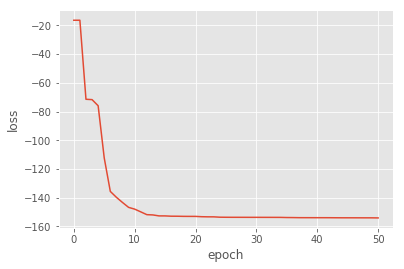

In [ ]:
cb = ContextualBandit({}, log = False)
cb.train(reco_log)
cb.plot_loss_history()

## Logged Contextual Bandit

100%|██████████| 50/50 [00:07<00:00,  7.75it/s]


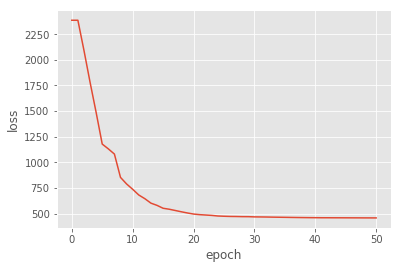

In [ ]:
log_cb = ContextualBandit({}, log = True)
log_cb.train(reco_log)
log_cb.plot_loss_history()

## Classical POEM

100%|██████████| 50/50 [00:26<00:00,  2.47it/s]


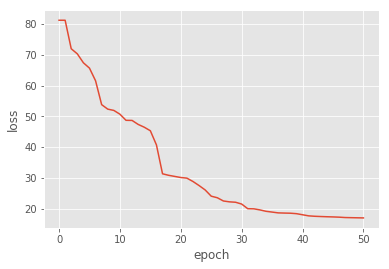

In [ ]:
poem = ContextualBandit({}, log = False, svp_lambda = .5)
poem.train(reco_log)
poem.plot_loss_history()

## Logged POEM

100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


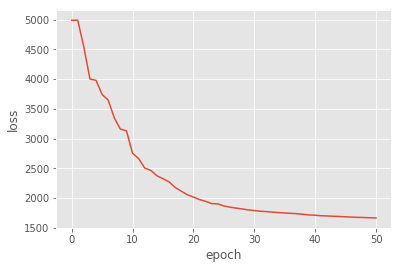

In [ ]:
log_poem = ContextualBandit({}, log = True, svp_lambda = 10)
log_poem.train(reco_log)
log_poem.plot_loss_history()

In [ ]:
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
                                                     'select_randomly': False,
                                                     'epsilon': 0.0}))

In [ ]:
%%time
result_AB = verify_agents(env,
                          5000,
                          {' User-pop': organic_counter_agent,
                           'Contextual Bandit': cb,
                           'Log-Contextual Bandit': log_cb,
                           'POEM': poem,
                           'Log-POEM': log_poem,
                          })
result_AB

In [ ]:
result_AB

In [ ]:
plot_verify_agents(result_AB)